In [1]:
from collections import OrderedDict
import warnings

import flwr as fl
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:537000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-3.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:537000]

aggregate_df1 = aggregate_df1.drop(['id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_test = aggregate_df1[~np.array(mask)]
X_train = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_test = plug1_1[~np.array(mask1)]
y_train = plug1_1[mask1]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True,
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

class Power_Generator(nn.Module):
    # Refer to "KASELIMI M, VOULODIMOS A, PROTOPAPADAKIS E, et al. EnerGAN: A GENERATIVE ADVERSARIAL NETWORK FOR ENERGY DISAGGREGATION[C].2020 ICASSP"
    def __init__(self):
        super(Power_Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size = 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 128, kernel_size = 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 64, kernel_size = 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 128, kernel_size = 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 256, kernel_size = 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 1, kernel_size = 32),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, power_seq):
        return self.model(power_seq)
    
class Power_Discriminator(nn.Module):
    # Refer to "KASELIMI M, VOULODIMOS A, PROTOPAPADAKIS E, et al. EnerGAN: A GENERATIVE ADVERSARIAL NETWORK FOR ENERGY DISAGGREGATION[C].2020 ICASSP"
    def __init__(self, sequence_length):
        super(Power_Discriminator, self).__init__()
        self.sequence_length = sequence_length
        self.model = nn.Sequential(
            nn.Conv1d(2, 512, kernel_size = 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 256, kernel_size = 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(13824, 60),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(60, 1),
            nn.Sigmoid()
        )

    def forward(self, mains_seq, app_seq):

        mains_app = torch.cat((mains_seq, app_seq), dim = 1)
        validity = self.model(mains_app)
        return validity
    
def initialize(layer):
    # Xavier_uniform will be applied to conv1d, convtranspose1d and dense layer, to be consistent with Keras and Tensorflow
    if isinstance(layer,nn.Conv1d) or isinstance(layer, nn.Linear) or isinstance(layer, nn.ConvTranspose1d):    
        torch.nn.init.xavier_uniform_(layer.weight.data)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, val = 0.0)
       
    
gen_model = Power_Generator()
dis_model = Power_Discriminator(100)
gen_model = gen_model.cuda()
dis_model = dis_model.cuda()
gen_model.apply(initialize)
dis_model.apply(initialize)
    
    
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr = 1e-3)
optimizer_D = torch.optim.Adam(dis_model.parameters(), lr = 1e-3)

adversarial_loss = torch.nn.BCELoss()
reconstruction_loss = torch.nn.L1Loss()
eval_loss = torch.nn.MSELoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gen_model = gen_model.to(device)
dis_model = dis_model.to(device)
adversarial_loss = adversarial_loss.to(device)
reconstruction_loss = reconstruction_loss.to(device)
eval_loss = eval_loss.to(device)

from torch.nn import L1Loss
import matplotlib.pyplot as plt
import tqdm




/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train(net, trainloader, epochs):
    for epoch in range(epochs):
        for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
            X_batch = torch.transpose(X_batch, 2, 1)
            y_batch = torch.transpose(y_batch, 2, 1)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            valid = torch.ones(batch_size, 1).float().to(device)
            fake = torch.zeros(batch_size, 1).float().to(device)

            # Generator Training
            gen_model.train()

            batch_pred = gen_model(X_batch)
            fake_labels = dis_model(batch_pred, X_batch)

            ad_loss = adversarial_loss(fake_labels, valid)
            pix_loss = reconstruction_loss(batch_pred, y_batch)
            gen_loss = ad_loss + 100 * pix_loss

            optimizer_G.zero_grad()    
            gen_loss.backward()
            optimizer_G.step()

            # Discriminator Training
            dis_model.train()
            true_labels = dis_model(y_batch, X_batch)

            fake_labels = dis_model(batch_pred.detach(), X_batch)

            real_loss = adversarial_loss(true_labels, valid)
            fake_loss = adversarial_loss(fake_labels, fake)
            dis_loss = (real_loss + fake_loss) / 2

            optimizer_D.zero_grad()    
            dis_loss.backward()
            optimizer_D.step()

        gen_model.eval()

        tqdm.tqdm.write(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], Gen Loss: {gen_loss.item()}, Dis Loss: {dis_loss.item()}")
        

In [3]:
net = Power_Discriminator(100)

class FlowerClient(fl.client.NumPyClient):
  def get_parameters(self, config):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

  def set_parameters(self, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

  def fit(self, parameters, config):
    self.set_parameters(parameters)
    train(net, train_loader, epochs=1)
    return self.get_parameters(config={}), len(train_loader.dataset), {}

#   def evaluate(self, parameters, config):
#     self.set_parameters(parameters)
#     gen_loss, dis_loss = test(net, test_loader)
#     return float(loss), len(test_loader.dataset), {"accuracy": float(accuracy)}

# Start Flower client
fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=FlowerClient())

INFO flower 2023-03-14 17:27:22,545 | grpc.py:50 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2023-03-14 17:27:22,547 | connection.py:38 | ChannelConnectivity.IDLE
DEBUG flower 2023-03-14 17:27:22,549 | connection.py:38 | ChannelConnectivity.READY
100%|███████████████████████████████████████| 7158/7158 [12:04<00:00,  9.88it/s]


Epoch [1/1], Step [7157/7158], Gen Loss: 674.1642456054688, Dis Loss: 50.000003814697266


100%|███████████████████████████████████████| 7158/7158 [12:20<00:00,  9.67it/s]


Epoch [1/1], Step [7157/7158], Gen Loss: 238.34860229492188, Dis Loss: 50.000003814697266


100%|███████████████████████████████████████| 7158/7158 [12:15<00:00,  9.73it/s]
DEBUG flower 2023-03-14 18:04:05,241 | connection.py:109 | gRPC channel closed
INFO flower 2023-03-14 18:04:05,242 | app.py:149 | Disconnect and shut down


Epoch [1/1], Step [7157/7158], Gen Loss: 1290.641845703125, Dis Loss: 50.000003814697266


In [4]:
predict = []
model = gen_model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = torch.transpose(inputs, 2, 1)
        labels = torch.transpose(labels, 2, 1)
        outputs = model(inputs)
        predict.append(outputs[:,:,0])
predict = torch.cat(predict, dim=0)
predict_list = predict.numpy()

In [5]:
predict_list = predict_list.reshape(-1)

In [6]:
predict_list.shape

(107280,)

In [7]:
y_test.shape

torch.Size([107400, 1])

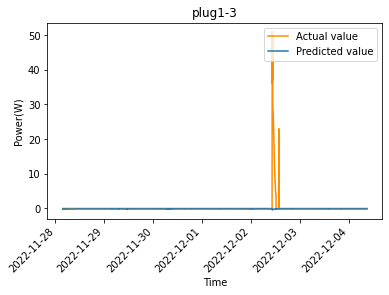

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_test = plug1_1[~np.array(mask1)]
y_test = pd.DataFrame(y_test[:-120])

y_test.index = pd.to_datetime(y_test.index, format='"%Y-%m-%d %H:%M:%S"')

# 將y_test轉換為NumPy陣列
y_test_np = y_test.to_numpy()

# 創建x軸數據
x = mdates.date2num(y_test.index)

# 繪製圖表

fig, ax = plt.subplots(facecolor='white')

ax.plot(x, y_test_np,label="Actual value",color='darkorange')
plt.plot(x,predict_list,label="Predicted value")

# 設置x軸格式
xfmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(xfmt)

# 設置x軸間隔為1天(1440分鐘)
xloc = mdates.MinuteLocator(interval=1440)
ax.xaxis.set_major_locator(xloc)

# 旋轉x軸標籤，以避免擠在一起
fig.autofmt_xdate(rotation=45)
# fig.subplots_adjust(right=1)
# 設置標籤
plt.xlabel('Time')
plt.ylabel('Power(W)')
plt.title('plug1-3')
plt.legend(loc='upper right')
plt.savefig('/home/awinlab/Documents/kevin/Energan/FedAvg/Energan_plug1-3.png')
plt.show()

In [9]:
# y_test_list = y_test.numpy()
# import csv

# with open('/home/awinlab/Documents/kevin/Energan/FedAvg/Energan110V.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     for i in range(1):
#         writer.writerow([])
#     for row1, row2 in zip(y_test_list[:-120],predict_list):
#         writer.writerow([row1[0], row2[0]])